In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 30
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

In [5]:
train_df.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [6]:
# pick random samples

dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
    try:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(1000)
    except:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)

In [7]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [8]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [9]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [10]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [11]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.1, 
                                                                        random_state=2020)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((37415,), (4158,), (37415, 42), (4158, 42))

In [12]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    
test_paths = np.array(test_paths)

In [13]:
def decode_image(filename, label=None, image_size=(456, 456)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

In [14]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_contrast(image, lower=0.75, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image = tf.image.random_hue(image, max_delta=0.2)
    
    if label is None:
        return image
    else:
        return image, label

> You also can use gridmask / cutmix / mixup etc for experiment

In [15]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [16]:
!pip install -q efficientnet

In [17]:
from tensorflow.keras.layers import Dense
from efficientnet.tfkeras import EfficientNetB7

## Use focal loss with label smoothing

In [18]:
import keras.backend as K

def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25,ls=0.1, classes=42.0):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
        y_ls = (1 - α) * y_hot + α / classes
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
        ls    -- label smoothing parameter(alpha)
        classes     -- No. of classes
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
        ls    -- 0.1
        classes     -- 40
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        #label smoothing
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        # Clip the prediction value
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred_ls)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred_ls), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

Using TensorFlow backend.


In [19]:
%%time

with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB7(weights='noisy-student', # imagenet
                       include_top=False,
                       pooling='avg'), # max
        Dense(42, activation='softmax')
    ])
    
    # model.layers[0].trainable = False
    
    model.compile(optimizer = 'adam',
                  loss = categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0), # num classes
                  metrics=['accuracy'])
    
    model.summary()

258072576/258068648 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 2560)              64097680  
_________________________________________________________________
dense (Dense)                (None, 42)                107562    
Total params: 64,205,242
Trainable params: 63,894,522
Non-trainable params: 310,720
_________________________________________________________________
CPU times: user 59.2 s, sys: 9.83 s, total: 1min 9s
Wall time: 1min 20s


In [20]:
n_steps = train_labels.shape[0] // BATCH_SIZE  # 88057 / 128 = 687

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
)

Epoch 1/30
292/292 [==============================] - 1044s 4s/step - loss: 0.9594 - accuracy: 0.5714 - val_loss: 0.6319 - val_accuracy: 0.7066
Epoch 2/30
292/292 [==============================] - 218s 746ms/step - loss: 0.6318 - accuracy: 0.6919 - val_loss: 0.5893 - val_accuracy: 0.7184
Epoch 3/30
292/292 [==============================] - 218s 746ms/step - loss: 0.5124 - accuracy: 0.7383 - val_loss: 0.5709 - val_accuracy: 0.7213
Epoch 4/30
292/292 [==============================] - 218s 746ms/step - loss: 0.4358 - accuracy: 0.7714 - val_loss: 0.5679 - val_accuracy: 0.7333
Epoch 5/30
292/292 [==============================] - 218s 747ms/step - loss: 0.3678 - accuracy: 0.7975 - val_loss: 0.6155 - val_accuracy: 0.7258
Epoch 6/30
292/292 [==============================] - 218s 746ms/step - loss: 0.3182 - accuracy: 0.8197 - val_loss: 0.6241 - val_accuracy: 0.7205
Epoch 7/30
292/292 [==============================] - 218s 747ms/step - loss: 0.2700 - accuracy: 0.8413 - val_loss: 0.6102 - v

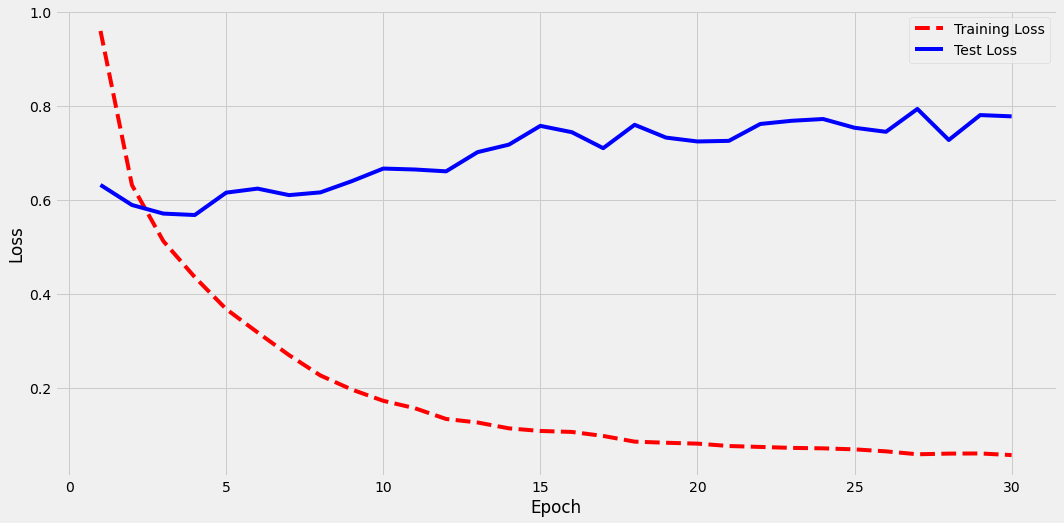

In [21]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [22]:
test_dataset_tta = (
        tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
)

tta_times = 5
probabilities = []

for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test_dataset_tta, verbose=1))
    
tta_pred = np.mean(probabilities, axis=0)

TTA Number:  0 

96/96 [==============================] - 326s 3s/step
TTA Number:  1 

96/96 [==============================] - 24s 245ms/step
TTA Number:  2 

96/96 [==============================] - 23s 244ms/step
TTA Number:  3 

96/96 [==============================] - 24s 245ms/step
TTA Number:  4 

96/96 [==============================] - 24s 245ms/step
TTA Number:  5 

96/96 [==============================] - 23s 244ms/step


In [23]:
# change with prediction
test_df['category'] = tta_pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [24]:
test_df.to_csv('B7_1000_trainable.csv', index=False)